In [1]:
setwd("..")

In [2]:
source("Source/functions.R")
library("data.table")
library("VennDiagram")
library("ggplot2")
library("pheatmap")
library("ape")

Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘ape’


The following object is masked from ‘package:VennDiagram’:

    rotate




In [3]:
chrmproperties <- fread(file = "Report/artifact/chrmbases_properties.csv.gz")
support_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
support_bypos <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_bypos.csv")
smito_pos <- support_byposmut[, unique(pos)]

In [4]:
strains_mclust <- read.csv("Report/strains/clustalo-17strains_str.tsv", sep = "\t", header = FALSE, as.is = TRUE)
bases <- lapply(strains_mclust[, 2], function(x) strsplit(x, "")[[1]])
unique(lengths(bases))

[1] 16315

In [5]:
bases <- do.call(cbind, bases)
strains <- strains_mclust[, 1]
colnames(bases) <- strains
pos_C57BL_6J <- cumsum(ifelse(bases[, which(strains == "C57BL/6J")] == "-", 0, 1))
strains_mclust <- data.frame(pos_C57BL_6J = pos_C57BL_6J, bases, stringsAsFactors = FALSE, check.names = FALSE)
head(strains_mclust)

,pos_C57BL_6J,129S1/SvImJ,AKR/J,A/J,BALB/cJ,C3H/HeJ,C57BL/6NJ,CAST/EiJ,CBA/J,DBA/2J,FVB/NJ,LP/J,NOD/ShiLtJ,NZO/HiLtJ,PWK/PhJ,SPRET/EiJ,WSB/EiJ,C57BL/6J,alignment
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,*
2,2,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,*
3,3,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,*
4,4,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,*
5,5,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,*
6,6,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,*


In [ ]:
fwrite(strains_mclust, file = "Report/strains/clustalo-17strains_base.csv")

## Make a fan tree

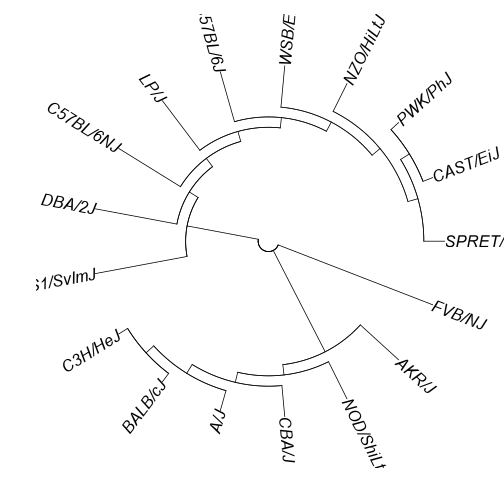

In [7]:
tree_17strains <- ape::read.tree("Report/strains/clustalo-17strains.ph")
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 72)
par(ps = 16, lend = 2, ljoin = 1, bty = "L", mfrow = c(1, 1), mar = c(2.5, 2.5, 1, 0), oma = c(0, 0, 0, 0), mgp = c(1.5, 0.5, 0))
plot.phylo(tree_17strains, type = "fan", use.edge.length = FALSE)

## SMITO-evo site overlap

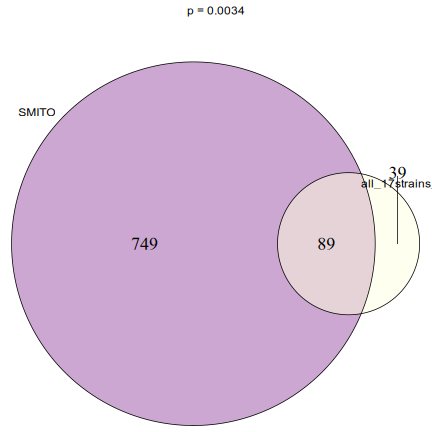

In [8]:
strains_mclust <- fread(file = "Report/strains/clustalo-17strains_base.csv")
setDT(strains_mclust)
setkey(strains_mclust, pos_C57BL_6J)
strains_mclust_varonly <- subset(strains_mclust, alignment != "*" & `C57BL/6J` != "-")
strains_mclust_varonly <- strains_mclust_varonly[, -c("alignment")]

options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 72)
fig <- venn.diagram(list(SMITO = smito_pos, `all_17strains_inrange` = intersect(chrmproperties[is_in_range == "Y" & is_in_primer == "N", pos], strains_mclust_varonly[, unique(pos_C57BL_6J)])), filename = NULL, main.fontfamily = "sans", sub.fontfamily = "sans", cat.fontfamily = "sans", hyper.test = TRUE, total.population = length(chrmproperties[is_in_range == "Y" & is_in_primer == "N", pos]), lower.tail = FALSE, main.cex = 1.5, cat.cex = 1, fill = c("#984EA3", "#FFFFE0"), cex = c(1, 1, 1) * 1.5, alpha = 0.5, lwd = 1)
grid.draw(fig)

### When SMITO is stratified by the number of mice sharing the SNV

In [9]:
smito_strains_x <- sapply(1:13, function(x) support_byposmut[nmice >= x, length(intersect(unique(pos), intersect(chrmproperties[is_in_range == "Y" & is_in_primer == "N", pos], strains_mclust_varonly[, unique(pos_C57BL_6J)])))])
smito_strains_k <- sapply(1:13, function(x) support_byposmut[nmice >= x, uniqueN(pos)])
smito_strains_m <- uniqueN(intersect(chrmproperties[is_in_range == "Y" & is_in_primer == "N", pos], strains_mclust_varonly[, unique(pos_C57BL_6J)]))
smito_strains_n <- chrmproperties[is_in_range == "Y" & is_in_primer == "N", .N] - smito_strains_m
smito_strains_pval <- phyper(q = smito_strains_x, k = smito_strains_k, n = rep(smito_strains_n, 13), m = rep(smito_strains_m, 13), lower.tail = FALSE)
smito_strains_obs <- smito_strains_x / smito_strains_k
smito_strains_bkg <- smito_strains_m / chrmproperties[is_in_range == "Y" & is_in_primer == "N", .N]
smito_strains_oddsratio <- smito_strains_obs / smito_strains_bkg

smito_strains_overlap <- data.table(
    nmice = 1:13, smito = smito_strains_k, `17strains` = smito_strains_m, 
    overlap = smito_strains_x, 
    frac_smito = smito_strains_obs, 
    frac_17strains = smito_strains_bkg, 
    oddsratio = smito_strains_oddsratio,
    pval = smito_strains_pval
)
head(smito_strains_overlap)

nmice,smito,17strains,overlap,frac_smito,frac_17strains,oddsratio,pval
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,838,128,89,0.10620525,0.08988764,1.1815334,0.003390242
2,366,128,32,0.08743169,0.08988764,0.9726776,0.528080498
3,152,128,14,0.09210526,0.08988764,1.0246711,0.389254067
4,72,128,8,0.11111111,0.08988764,1.2361111,0.191247734
5,46,128,6,0.13043478,0.08988764,1.4510870,0.111734141
6,29,128,4,0.13793103,0.08988764,1.5344828,0.111832241


In [ ]:
fwrite(smito_strains_overlap, file = "Report/strains/smito_17strains-inrange_overlap.csv")

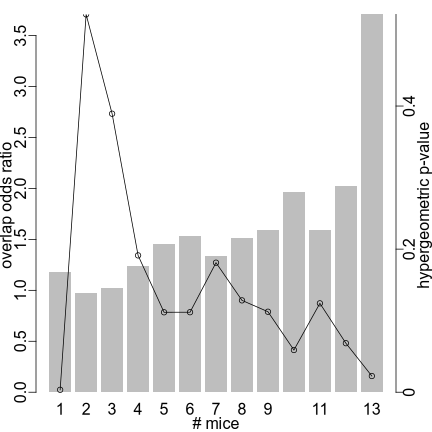

In [11]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 72)
par(ps = 16, lend = 2, ljoin = 1, bty = "L", mfrow = c(1, 1), mar = c(2.5, 2.5, 1, 2.5), oma = c(0, 0, 0, 0), mgp = c(1.5, 0.5, 0))
x <- barplot(smito_strains_overlap[, oddsratio], names.arg = 1:13, border = FALSE)
lines(x = x, y = smito_strains_overlap[, pval * max(oddsratio)/max(pval)])
points(x = x, y = smito_strains_overlap[, pval * max(oddsratio)/max(pval)])
axis(side = 4, at = seq(0, smito_strains_overlap[, 0.6 * max(oddsratio) / max(pval)], length.out = 4), labels = seq(0, 0.6, by = 0.2))
title(ylab = "overlap odds ratio")
mtext("hypergeometric p-value", side = 4, line = 1.5)
mtext("# mice", side = 1, line = 1.5)

### Test whether (1) the major alleles, (2) the top minor alleles from SMITO match the population data

In [12]:
highdepth_highaf <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd.csv.gz")
highdepth_highaf_noctrl_17strains <- highdepth_highaf[IsCtrl == "N" & pos %in% strains_mclust_varonly[, unique(pos_C57BL_6J)]]
highdepth_highaf_noctrl_17strains <- strains_mclust_varonly[highdepth_highaf_noctrl_17strains, on = c("pos_C57BL_6J" = "pos")]
setnames(highdepth_highaf_noctrl_17strains, "pos_C57BL_6J", "pos")

highdepth_highaf_noctrl_17strains[ref == "A", A := `=`]
highdepth_highaf_noctrl_17strains[ref == "C", C := `=`]
highdepth_highaf_noctrl_17strains[ref == "G", G := `=`]
highdepth_highaf_noctrl_17strains[ref == "T", T := `=`]

smito_avgaf <- highdepth_highaf_noctrl_17strains[, { X <- colSums(t(sapply(1:nrow(.SD), function(x) { unlist(.SD[x, 1]) * unlist(.SD[x, -1]) }))); as.list(100 * X / sum(X)) }, keyby = "pos", .SDcols = c("depth", "A", "C", "G", "T", "del")]
smito_avgaf <- support_bypos[smito_avgaf, on = "pos"]

evo17strains <- strains_mclust_varonly[pos_C57BL_6J %in% highdepth_highaf_noctrl_17strains[, pos]]
setnames(evo17strains, "pos_C57BL_6J", "pos")

evo17strains_avgaf <- evo17strains[, as.list(table(factor(.SD, levels = c("A", "C", "G", "T", "-"))) / 17 * 100), keyby = "pos"]
setnames(evo17strains_avgaf, "-", "del")

smito_evo17strains_avgaf <- merge.data.table(smito_avgaf, evo17strains_avgaf, by.x = "pos", by.y = "pos")
setnames(smito_evo17strains_avgaf, 
    c("A.x", "C.x", "G.x", "T.x", "del.x", "A.y", "C.y", "G.y", "T.y", "del.y"), 
    c("smito_A", "smito_C", "smito_G", "smito_T", "smito_del", "evo_A", "evo_C", "evo_G", "evo_T", "evo_del")
)

smito_evo17strains_avgaf <- chrmproperties[smito_evo17strains_avgaf[, -"SNVID"], on = "pos"]

smito_major <- smito_evo17strains_avgaf[, apply(.SD, 1, function(x) c("A", "C", "G", "T", "del")[which.max(x)]), .SD = c("smito_A", "smito_C", "smito_G", "smito_T", "smito_del")]
evo17strains_major <- smito_evo17strains_avgaf[, apply(.SD, 1, function(x) c("A", "C", "G", "T", "del")[which.max(x)]), .SD = c("evo_A", "evo_C", "evo_G", "evo_T", "evo_del")]
smito_topminor <- smito_evo17strains_avgaf[, apply(.SD, 1, function(x) { z <- c("A", "C", "G", "T", "del"); y <- match(x[1], z); i <- which.max(x[-1][-y]); z[-y][i] }), .SDcols = c("ref", "smito_A", "smito_C", "smito_G", "smito_T", "smito_del")]
evo17strains_topminor <- smito_evo17strains_avgaf[, apply(.SD, 1, function(x) { z <- c("A", "C", "G", "T", "del"); y <- match(x[1], z); i <- which.max(x[-1][-y]); z[-y][i] }), .SDcols = c("ref", "evo_A", "evo_C", "evo_G", "evo_T", "evo_del")]
smito_evo17strains_avgaf[, smito_major := smito_major]
smito_evo17strains_avgaf[, evo_major := evo17strains_major]
smito_evo17strains_avgaf[, smito_topminor := smito_topminor]
smito_evo17strains_avgaf[, evo_topminor := evo17strains_topminor]
head(smito_evo17strains_avgaf)

pos,SNVID,ref,is_softmasked,nhomopolymer,does_new_begin,does_old_end,basefrac_bin10_A,basefrac_bin10_C,basefrac_bin10_G,⋯,smito_del,evo_A,evo_C,evo_G,evo_T,evo_del,smito_major,evo_major,smito_topminor,evo_topminor
<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1235,SNV12,T,N,1,1,1,0.5454545,0.09090909,0.09090909,⋯,0.0000000,0.00000,5.882353,0.00000,94.117647,0.000000,T,T,G,C
1248,SNV12,G,N,1,1,1,0.6363636,0.09090909,0.18181818,⋯,0.0000000,17.64706,0.000000,82.35294,0.000000,0.000000,G,G,T,A
1251,SNV12,C,N,1,1,1,0.6363636,0.18181818,0.18181818,⋯,0.0000000,0.00000,94.117647,0.00000,5.882353,0.000000,C,C,T,T
2615,SNV10,T,N,2,1,0,0.3636364,0.18181818,0.00000000,⋯,0.0000000,0.00000,5.882353,0.00000,94.117647,0.000000,T,T,C,C
2628,SNV10,A,N,4,1,0,0.5454545,0.09090909,0.09090909,⋯,0.4929577,94.11765,0.000000,0.00000,0.000000,5.882353,A,A,G,del
2635,SNV10,A,N,3,1,0,0.6363636,0.09090909,0.00000000,⋯,0.0000000,94.11765,0.000000,0.00000,5.882353,0.000000,A,A,G,T


In [ ]:
fwrite(smito_evo17strains_avgaf, file = "Report/strains/smito_17strains_avgaf.csv")

In [14]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ape_5.8             pheatmap_1.0.12     ggplot2_3.5.1      
[4] VennDiagram_1.7.3   futile.logger_1.4.3 data.table_1.16.2  

loaded via a namespace (and not